In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from models.graph_water_transformer_cov_no_gcn import graph_water_transformer_cov_gate_predictor_no_gcn

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1


import random

random.seed(10)
print(random.random())

2023-08-12 12:30:50.996476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 12:30:52.499595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.5714025946899135


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [4]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [5]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

#### Gate & pump predictor

In [6]:
# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
gate_min = 0.0
gate_max = 1.0

learning_rate = 3e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 700
BATCH = 512

In [7]:
input_shape = train_cov.shape[1:]

In [8]:
gate_predictor, GCNConv = graph_water_transformer_cov_gate_predictor_no_gcn(input_shape=input_shape,
                                                                            lstm_unit=lstm_units, 
                                                                            num_transformer_blocks=num_transformer_blocks, 
                                                                            head_size=head_size, 
                                                                            num_heads=num_heads, 
                                                                            ff_dim=ff_dim, 
                                                                            atte_reg=atte_reg, 
                                                                            l1_reg=l1_reg, 
                                                                            l2_reg=l2_reg, 
                                                                            dropout=dropout,
                                                                            masked_value=masked_value,
                                                                            gate_min=gate_min,
                                                                            gate_max=gate_max,
                                                                           )
gate_predictor._name = "gate_predictor"
gate_predictor.summary()

2023-08-12 12:31:02.097666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


Model: "gate_predictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cov_inputs (InputLayer)     [(None, 96, 12)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 96, 12)               0         ['cov_inputs[0][0]']          
                                                                                                  
 multi_head_attention (Mult  (None, 96, 12)               29388     ['masking[0][0]',             
 iHeadAttention)                                                     'masking[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 96, 12)               0         ['multi_head_atte

In [9]:
gate_predictor.compile(optimizer='adam', loss='mse')

#### water stage predictor

In [10]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

#### Combine gate_predictor and trained ws_predictor

In [11]:
inputs_cov = Input(shape=(96, 12), name='input_cov')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor([inputs_cov, inputs_tws])  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_cov[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_cov[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs_cov = layers.Concatenate(axis=1)([inputs_cov[:, :n_hours, :], replaced_future_gate_pump])

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_cov, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
# filda.summary()

Epoch 1/700


2023-08-12 12:31:20.832168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-12 12:31:22.244215: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ed6027760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-12 12:31:22.244264: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-12 12:31:22.253637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-12 12:31:22.669467: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_ws_predictor_loss improved from inf to 3.05294, saving model to ../saved_models/gtnp_gtnp_13_no_gcn.h5
151/151 - 38s - loss: 0.5016 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2383 - val_loss: 6.1092 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 3.0529 - 38s/epoch - 253ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss did not improve from 3.05294
151/151 - 21s - loss: 0.4791 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2381 - val_loss: 6.4781 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 3.2379 - 21s/epoch - 141ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss improved from 3.05294 to 1.83432, saving model to ../saved_models/gtnp_gtnp_13_no_gcn.h5
151/151 - 21s - loss: 0.4620 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2299 - val_loss: 3.6714 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.8343 - 21s/epoch - 142ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss improved from 1.83432 to 1.60879, saving model to ../saved_models/gtnp_gtnp_13_no_gcn.h5
151/151 - 21s - loss: 0.4032 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2004 - val_loss: 3.2197 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6088 - 21s/epoch - 140ms/step
Epoch 5/700

Epoch 5: val_ws_predictor_loss improved from 

Epoch 31/700

Epoch 31: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3836 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1914 - val_loss: 3.5488 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7740 - 21s/epoch - 142ms/step
Epoch 32/700

Epoch 32: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3828 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1910 - val_loss: 3.4680 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7336 - 21s/epoch - 140ms/step
Epoch 33/700

Epoch 33: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3827 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1910 - val_loss: 3.5211 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7602 - 21s/epoch - 140ms/step
Epoch 34/700

Epoch 34: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3825 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0

151/151 - 21s - loss: 0.3818 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1906 - val_loss: 3.3972 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6983 - 21s/epoch - 140ms/step
Epoch 61/700

Epoch 61: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3821 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1907 - val_loss: 3.4115 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7055 - 21s/epoch - 139ms/step
Epoch 62/700

Epoch 62: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3817 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1906 - val_loss: 3.3899 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6947 - 21s/epoch - 139ms/step
Epoch 63/700

Epoch 63: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3817 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1906 - val_loss: 3.3756 - val_gate_predictor_loss: 0.0000e+00 - val_ws_pre

Epoch 90/700

Epoch 90: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3818 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1906 - val_loss: 3.3800 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6897 - 21s/epoch - 139ms/step
Epoch 91/700

Epoch 91: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3816 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1905 - val_loss: 3.4057 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7026 - 21s/epoch - 138ms/step
Epoch 92/700

Epoch 92: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3815 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1905 - val_loss: 3.3617 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6806 - 21s/epoch - 138ms/step
Epoch 93/700

Epoch 93: val_ws_predictor_loss did not improve from 1.59679
151/151 - 21s - loss: 0.3834 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0

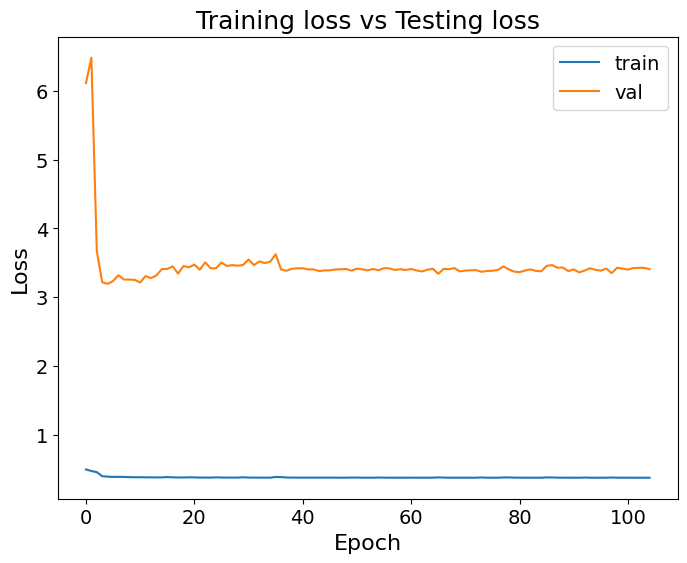

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 2.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/gtnp_gtnp_13_no_gcn.h5'.format(n_hours, K),
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_cov, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_cov, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,
                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [13]:
saved_model = load_model('../saved_models/gtnp_gtnp_13_no_gcn.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [14]:
gate_pump_pred, ws_pred = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)

603/603 [==============================] - 12s 18ms/step
(19268, 24, 7)
(19268, 96)


#### ws pred, gate pred

In [15]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [16]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [17]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [18]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 56, 46, 86, 89
S1, S25A, S25B, S26 areas: 5.901, 4.839, 10, 12.3557
TOTAL time steps: 277; TOTAL areas: 33.0337
--------------------------------------------------


In [19]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 2, 2, 5, 3
S1, S25A, S25B, S26 areas: 0.1469, 0.116, 0, 0.2798
TOTAL time steps: 12; TOTAL areas: 0.8861
--------------------------------------------------


In [20]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 12884, areas: 2409.122174024582


### Lower threshold

In [21]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 479, 83, 45, 204
S1, S25A, S25B, S26 areas: -86.2229, -8.5077, -5.0224, -32.8631:
TOTAL time steps: 811; TOTAL areas: -132.6161
--------------------------------------------------


In [22]:
drought_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------


In [23]:
drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 14954, areas: 2426.1538068996733


In [24]:
ws_true_gate_true_inv_24 = ws_true_gate_true_inv[:, t1, :]
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv[:, t1, :]
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv[:, t1, :]

ws_true_gate_true_inv_24 = ws_true_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv_24.reshape((-1, 1, 4))

drought_threshold(ws_true_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv_24, lower_threshold)

time steps: 5166, areas: 1465.099992136471
time steps: 5575, areas: 1570.7175889443388
time steps: 811, areas: 132.61614197987365
